## Task

For this assignment, you will revisit your first project to predict supermarket sales. You will apply what you've learned this week to explain how your models made their predictions.

## Project 1 Revisited - Part 1: Remaking, Saving, and Explaining Your Models

For this part of the project, you will be producing a new version of your final project notebook using the updated tools in sklearn v1.2. You should continue to save your work in the same repo as your original Project 1. 

- Create a new notebook called "Project 1 - Revisited.ipynb" in your original project repo.
  - You may either make a copy of your prior notebook that you will modify, or you can start a new blank notebook and copy over the code from your old notebook (as needed).
- Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.

#### LinearRegression

- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.
  - Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).

#### Tree-Based Model

- Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.
- Extract and visualize the feature importances that your model determined.
 - Identify the top 5 most important features.
- Save your figure as a .png file inside your repository  (you will need this for the final piece of this assignment - Update Your README).

#### Serialize Your Best Models with Joblib

- Once you've finished updating and explaining your models, you must save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib":
- "preprocessor": your preprocessing  column transformer
- "X_train": your training features.
- "X_test": your test features.
- "y_train": your training target.
- "y_test": your test target.
- "LinearRegression": your best linear regression
- Your tree-based model's class name: your best tree-based model.
 - e.g. "RandomForestRegressor"/"DecisionTreeRegressor"
- Save your joblib file inside your repository. (You will work with these models again in the next core assignment.)

---

## Loading Imports & Data

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import set_config


import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib 
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [229]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,as_frame=True):
  """Evaluates a scikit learn regression model using r-squared and RMSE.
  Returns the results a DataFrame if as_frame is True (Default).
  """
  ## Training Data
  y_pred_train = model.predict(X_train)
  r2_train = metrics.r2_score(y_train, y_pred_train)
  rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                          squared=False)
  mae_train = metrics.mean_absolute_error(y_train, y_pred_train)


  ## Test Data
  y_pred_test = model.predict(X_test)
  r2_test = metrics.r2_score(y_test, y_pred_test)
  rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                          squared=False)
  mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

  ## if returning a dataframe:
  if as_frame:
      df_version =[['Split','R^2','MAE','RMSE']]
      df_version.append(['Train',r2_train, mae_train, rmse_train])
      df_version.append(['Test',r2_test, mae_test, rmse_test])
      df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
      df_results = df_results.round(2)


      # adapting hide_index for pd version
      if pd.__version__ < "1.4.0":
        display(df_results.style.hide_index().format(precision=2, thousands=','))
      else:
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))

  ## If not dataframe, just print results.
  else:
      print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
      print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [230]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQujSPVdp1EfFsngrLgWZZ_VT_I7nuzXs10BqUJV5ai8hFZoUDf3mpA68wj37UFVfS3yvj_QvvO6655/pub?gid=1913766112&single=true&output=csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3000,Low Fat,0.0160,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.1380"
1,DRC01,5.9200,Regular,0.0193,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5000,Low Fat,0.0168,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.2700"
3,FDX07,19.2000,Regular,0.0000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.9300,Low Fat,0.0000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [231]:
df.columns = df.columns.str.strip()
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3000,Low Fat,0.0160,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,"3,735.1380"
1,DRC01,5.9200,Regular,0.0193,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5000,Low Fat,0.0168,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,"2,097.2700"
3,FDX07,19.2000,Regular,0.0000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.9300,Low Fat,0.0000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.8650,Low Fat,0.0568,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,"2,778.3834"
8519,FDS36,8.3800,Regular,0.0470,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.6000,Low Fat,0.0352,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,"1,193.1136"
8521,FDN46,7.2100,Regular,0.1452,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,"1,845.5976"


In [232]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [233]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.0000","8,523.0000","8,523.0000","8,523.0000","8,523.0000"
mean,12.8576,0.0661,140.9928,"1,997.8319","2,181.2889"
std,4.6435,0.0516,62.2751,8.3718,"1,706.4996"
min,4.5550,0.0000,31.2900,"1,985.0000",33.2900
25%,8.7737,0.0270,93.8265,"1,987.0000",834.2474
50%,12.6000,0.0539,143.0128,"1,999.0000","1,794.3310"
75%,16.8500,0.0946,185.6437,"2,004.0000","3,101.2964"
max,21.3500,0.3284,266.8884,"2,009.0000","13,086.9648"


In [234]:
df['Outlet_Size']= df['Outlet_Size'].fillna(value = 'Unknown')

In [235]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [236]:
data_types = df.dtypes
object_data_types = data_types[(data_types == "object")]
object_data_types

Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object

In [237]:
object_data_types.index

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [238]:
for column in object_data_types.index:
    
    print(column)
    print(df[column].unique())
    print('\n')

Item_Identifier
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']


Item_Fat_Content
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']


Item_Type
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


Outlet_Identifier
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


Outlet_Size
['Medium' 'Unknown' 'High' 'Small']


Outlet_Location_Type
['Tier 1' 'Tier 3' 'Tier 2']


Outlet_Type
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']




In [239]:
df.replace({'reg': 'Regular', 'low fat': 'Low Fat', 'LF': 'Low Fat'}, inplace = True)

In [240]:
for column in object_data_types.index:
    
    print(column)
    print(df[column].unique())
    print('\n')

Item_Identifier
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']


Item_Fat_Content
['Low Fat' 'Regular']


Item_Type
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']


Outlet_Identifier
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


Outlet_Size
['Medium' 'Unknown' 'High' 'Small']


Outlet_Location_Type
['Tier 1' 'Tier 3' 'Tier 2']


Outlet_Type
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']




### Visualizing Final Target

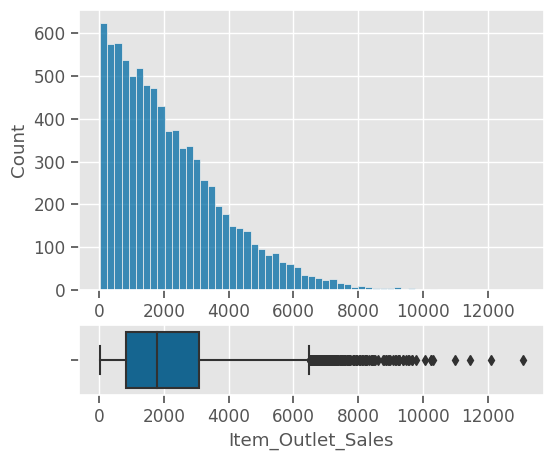

In [241]:
target = 'Item_Outlet_Sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=df, x=target,ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1]);

### Preprocessing 

In [242]:
target = "Item_Outlet_Sales"
drop_feats=[]

y = df[target].copy()
X = df.drop(columns=[target,*drop_feats]).copy()


X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(5)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,FDI60,7.2200,Regular,0.0641,Baking Goods,61.2510,OUT010,1998,Unknown,Tier 3,Grocery Store
7604,DRD25,6.1350,Low Fat,0.0793,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,NCP18,12.1500,Low Fat,0.0286,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,NCS30,5.9450,Low Fat,0.0930,Household,127.8652,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,FDI08,18.2000,Regular,0.0663,Fruits and Vegetables,247.2092,OUT035,2004,Small,Tier 2,Supermarket Type1


In [243]:
num_sel = make_column_selector(dtype_include='number')
mean_imputer = SimpleImputer(strategy='mean')

num_tuple = ('Numeric', mean_imputer, num_sel)

In [244]:
X_train = X_train.drop(columns='Item_Identifier')
X_test = X_test.drop(columns='Item_Identifier')

In [245]:
cat_sel = make_column_selector(dtype_include='object')

cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', 
                                       sparse=False,
                                       drop='if_binary'))

cat_tuple = ('Categorical', cat_pipe, cat_sel)

In [246]:
preprocessor = ColumnTransformer([num_tuple, cat_tuple],
                                verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('Numeric', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB6D5EBEE0>),
                                ('Categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB6D5EB520>)],
                  verbose_feature_names_out=False)

In [247]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('Numeric', SimpleImputer(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB6D5EBEE0>),
                                ('Categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CB6D5EB520>)],
                  verbose_feature_names_out=False)

In [248]:
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)


In [249]:
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_High', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Size_Unknown', 'Outlet_Location_Type_Tier 1',
   

## Linear Regression

In [250]:
from sklearn.linear_model import LinearRegression

In [251]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_proc, y_train)
evaluate_regression(lin_reg, X_train_proc, y_train, 
                    X_test_proc, y_test)

Split,R^2,MAE,RMSE
Train,0.56,826.79,"1,114.98"
Test,0.56,859.97,"1,164.41"


In [252]:
lin_reg.coef_

array([   1.06785557, -276.61155652,   15.60194362,  -14.22042061,
         31.37658854,    8.97739258,   -4.09219017,   69.88439671,
         22.60032924,  -48.84338125,   -5.40780071,   16.17362127,
         49.13525181,  -41.49960301,  -68.64200308,  -15.91206968,
         17.60709784,   98.50049025,  -11.70291833, -117.85587742,
         31.07726395, -420.53817385,  -67.99342481,  213.17870445,
        -87.01125117, -464.15320226,  585.45414205,   66.8404385 ,
        -39.83389775,  301.24207912,  -87.18541427,  -67.99342481,
        411.25747661,  -96.07068464, -247.19336716, -250.09653741,
        240.18524519,    9.91129222, -884.69137611,  386.24848523,
        -87.01125117,  585.45414205])

In [253]:
lin_reg.intercept_

28116.30585695631

In [254]:
len(feature_names)

42

In [255]:
coef_df = pd.Series(lin_reg.coef_, index=feature_names)
coef_df

Item_Weight                          1.0679
Item_Visibility                   -276.6116
Item_MRP                            15.6019
Outlet_Establishment_Year          -14.2204
Item_Fat_Content_Regular            31.3766
Item_Type_Baking Goods               8.9774
Item_Type_Breads                    -4.0922
Item_Type_Breakfast                 69.8844
Item_Type_Canned                    22.6003
Item_Type_Dairy                    -48.8434
Item_Type_Frozen Foods              -5.4078
Item_Type_Fruits and Vegetables     16.1736
Item_Type_Hard Drinks               49.1353
Item_Type_Health and Hygiene       -41.4996
Item_Type_Household                -68.6420
Item_Type_Meat                     -15.9121
Item_Type_Others                    17.6071
Item_Type_Seafood                   98.5005
Item_Type_Snack Foods              -11.7029
Item_Type_Soft Drinks             -117.8559
Item_Type_Starchy Foods             31.0773
Outlet_Identifier_OUT010          -420.5382
Outlet_Identifier_OUT013        

In [256]:
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")

In [257]:
coef_df

Item_Weight                          1.0679
Item_Visibility                   -276.6116
Item_MRP                            15.6019
Outlet_Establishment_Year          -14.2204
Item_Fat_Content_Regular            31.3766
Item_Type_Baking Goods               8.9774
Item_Type_Breads                    -4.0922
Item_Type_Breakfast                 69.8844
Item_Type_Canned                    22.6003
Item_Type_Dairy                    -48.8434
Item_Type_Frozen Foods              -5.4078
Item_Type_Fruits and Vegetables     16.1736
Item_Type_Hard Drinks               49.1353
Item_Type_Health and Hygiene       -41.4996
Item_Type_Household                -68.6420
Item_Type_Meat                     -15.9121
Item_Type_Others                    17.6071
Item_Type_Seafood                   98.5005
Item_Type_Snack Foods              -11.7029
Item_Type_Soft Drinks             -117.8559
Item_Type_Starchy Foods             31.0773
Outlet_Identifier_OUT010          -420.5382
Outlet_Identifier_OUT013        

In [258]:
def get_coefficients(lin_reg):
    coefs = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_)
    return coefs

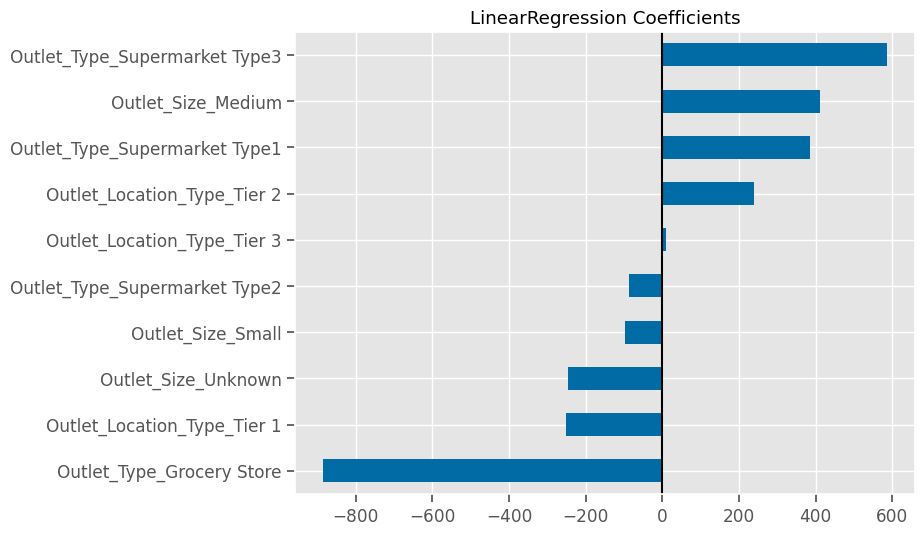

In [281]:
ax = coef_df.tail(10).sort_values().plot(kind='barh',figsize=(8,6))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

We can tell based on the top Linear Coefficients that we have positive and negative coefficients with Supermarket type having positive and Grocery Store being the negative.

## Feature Importance - Tree-Based Model

In [260]:
from sklearn.ensemble import RandomForestRegressor

In [261]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_proc, y_train)
evaluate_regression(rf_reg, X_train_proc, y_train, 
                    X_test_proc, y_test)

Split,R^2,MAE,RMSE
Train,0.94,292.63,423.76
Test,0.56,814.91,"1,163.88"


In [262]:
importances = rf_reg.feature_importances_
importances

array([5.38390405e-02, 9.74500103e-02, 4.44395402e-01, 2.79576690e-02,
       8.26281341e-03, 4.50134922e-03, 2.90891467e-03, 2.52064803e-03,
       4.36220853e-03, 5.52244524e-03, 5.83036039e-03, 8.47066264e-03,
       3.04718644e-03, 4.18550078e-03, 6.42471475e-03, 3.57107724e-03,
       1.63550113e-03, 1.36273846e-03, 8.17931038e-03, 4.21177083e-03,
       3.08992034e-03, 9.43408095e-06, 1.65114331e-03, 3.05057446e-03,
       9.77140443e-04, 1.29114369e-05, 2.98492324e-02, 3.86850927e-03,
       4.90585980e-03, 3.09459836e-03, 3.18195323e-03, 1.49695160e-03,
       2.99613219e-03, 4.06950016e-03, 3.15358943e-03, 3.24501195e-03,
       2.72497181e-03, 2.57328894e-03, 1.96758190e-01, 1.86950898e-03,
       1.02995732e-03, 2.77522968e-02])

In [263]:
print(len(rf_reg.feature_importances_))
print(len(X_train_proc))
len(rf_reg.feature_importances_) == len(X_train_proc)

42
6392


False

In [264]:
importances = pd.Series(rf_reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                       0.0538
Item_Visibility                   0.0975
Item_MRP                          0.4444
Outlet_Establishment_Year         0.0280
Item_Fat_Content_Regular          0.0083
Item_Type_Baking Goods            0.0045
Item_Type_Breads                  0.0029
Item_Type_Breakfast               0.0025
Item_Type_Canned                  0.0044
Item_Type_Dairy                   0.0055
Item_Type_Frozen Foods            0.0058
Item_Type_Fruits and Vegetables   0.0085
Item_Type_Hard Drinks             0.0030
Item_Type_Health and Hygiene      0.0042
Item_Type_Household               0.0064
Item_Type_Meat                    0.0036
Item_Type_Others                  0.0016
Item_Type_Seafood                 0.0014
Item_Type_Snack Foods             0.0082
Item_Type_Soft Drinks             0.0042
Item_Type_Starchy Foods           0.0031
Outlet_Identifier_OUT010          0.0000
Outlet_Identifier_OUT013          0.0017
Outlet_Identifier_OUT017          0.0031
Outlet_Identifie

In [265]:
importances.sum()

1.0000000000000002

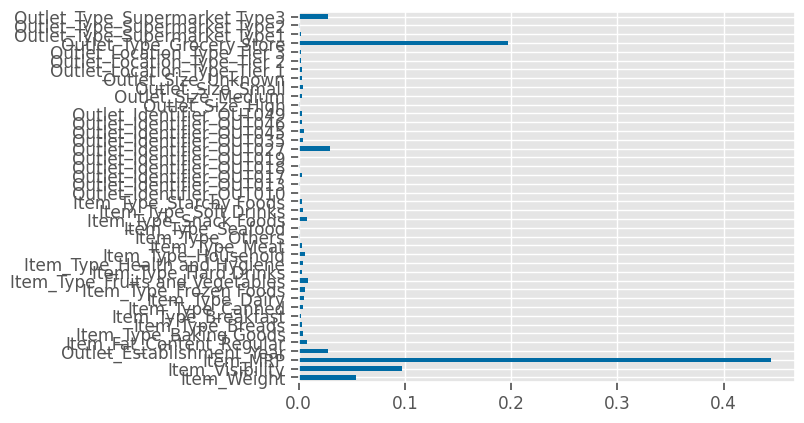

In [266]:
ax = importances.plot(kind='barh')

In [267]:
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

Item_MRP                          0.4444
Outlet_Type_Grocery Store         0.1968
Item_Visibility                   0.0975
Item_Weight                       0.0538
Outlet_Identifier_OUT027          0.0298
Outlet_Establishment_Year         0.0280
Outlet_Type_Supermarket Type3     0.0278
Item_Type_Fruits and Vegetables   0.0085
Item_Fat_Content_Regular          0.0083
Item_Type_Snack Foods             0.0082
Item_Type_Household               0.0064
Item_Type_Frozen Foods            0.0058
Item_Type_Dairy                   0.0055
Outlet_Identifier_OUT045          0.0049
Item_Type_Baking Goods            0.0045
Item_Type_Canned                  0.0044
Item_Type_Soft Drinks             0.0042
Item_Type_Health and Hygiene      0.0042
Outlet_Size_Small                 0.0041
Outlet_Identifier_OUT035          0.0039
Item_Type_Meat                    0.0036
Outlet_Location_Type_Tier 1       0.0032
Outlet_Identifier_OUT049          0.0032
Outlet_Size_Unknown               0.0032
Outlet_Identifie

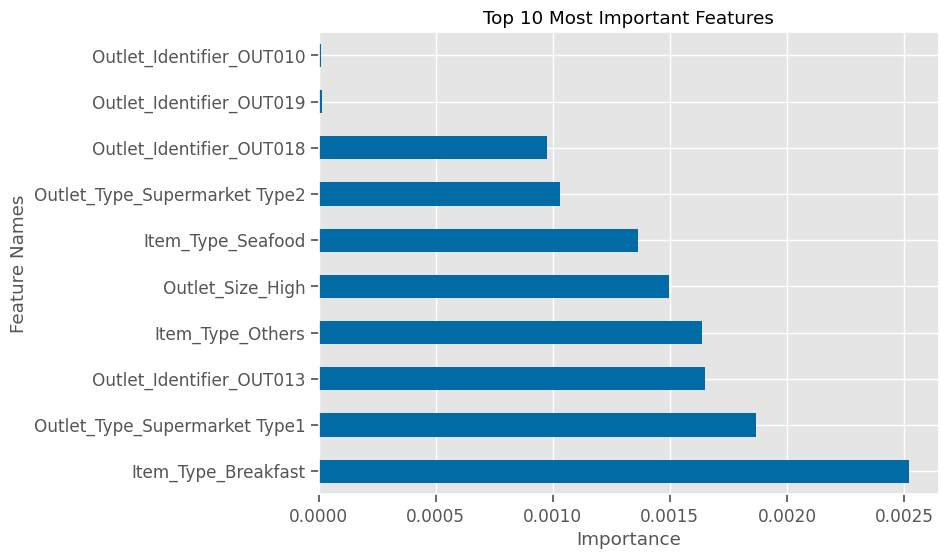

In [268]:
ax = sorted_importance.tail(10).plot(kind='barh',
                                   figsize=(8,6))
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features');

We have narrowed down our Important Values to the top 10. Based on the figure above, we can deduce that Type Item Breakfast is one of the most important feature.

### Joblib

In [274]:
import joblib, os

In [275]:
to_save = {'X_train': X_train,
          'X_test':X_test,
          'y_train':y_train,
          'y_test':y_test,
          'preprocessor':preprocessor,
          'RandomForestRegressor':rf_reg,
          'LinearRegression':lin_reg,
          'preprocessor':preprocessor}

In [276]:
folder = '../PNG/'
filename = 'Project 1 Revisited Importances and Coefficients.joblib'
os.makedirs(folder, exist_ok=True)

In [277]:
joblib.dump(to_save, folder + filename)

['../PNG/Project 1 Revisited Importances and Coefficients.joblib']

In [278]:
saved_stuff = joblib.load(folder + filename)
saved_stuff.keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'preprocessor', 'RandomForestRegressor', 'LinearRegression'])